

## Milestone 2: Acquire and Understand Data


**Project 57**<br/>
**Due: November 3, 2023**<br/>
**Team**: Hannah Boen, Gabe LeBlanc, Ethan Tran

---

#### Resources
- BRFSS dataset from proposal: https://www.cdc.gov/brfss/annual_data/annual_data.htm
- Referenced codebooks from link above
- BRFSS files in accessible csv format: https://osf.io/6rxf4/
- Used 2017-2021 data from link above

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from datetime import datetime

### About the BRFSS (From the BRFSS Overview 2022)

The **Behavioral Risk Factor Surveillance Survey**, or BRFSS, is a project by the **Center for Disease Control and Prevention** (CDC) that consists of ongoing health-related *telephone surveys*. The BRFSS collects data on risk behaviors, chronic health conditions, healthcare access, and use of preventative servies among noninstitutionalized adults ($\geq$ 18 years). This information is used by state governments to identify demographic variations in health-related behaviors and creating public health programs.

## <div class='exercise'><b> Data Missingness</b></div>

#### Cleaning Example (2017 data)

In [2]:
# Example with 2017
df = pd.read_csv("data/BRFSS2017.csv", low_memory=False)
print(df.shape)

(450016, 358)


In [3]:
# print out all columns that have missing values
cols_with_missingness = df.isna().sum()
print(cols_with_missingness[cols_with_missingness > 0])

ctelenm1    252560
pvtresd1    252560
colghous    449975
statere1    252560
cellfon4    252560
             ...  
pavig21_    162062
pa1vigm_    155153
_flshot6    287398
_pneumo2    287398
_aidtst3     41672
Length: 285, dtype: int64


In [4]:
# there are many columns with missingness! if so many values for a column are missing, 
# prediction will be very inaccurate so let's drop those rows

# thresh says keep all columns with at least 400,000 non-NA rows
df_2 = df.dropna(axis=1, thresh=400000)
print(df_2.shape)
cols_with_missingness_2 = df_2.isna().sum()
print(cols_with_missingness_2[cols_with_missingness_2 > 0])

(450016, 151)
genhlth         3
physhlth        1
menthlth        1
hlthpln1        1
persdoc2        3
            ...  
vegeda2_    37252
_frutsu1    39357
_vegesu1    47460
strfreq_    41439
_aidtst3    41672
Length: 78, dtype: int64


In [5]:
# For the rest, we can imput the mean
# Can change this to incorporate training and testing data later
df_clean = df_2.copy()
for column in df_clean.columns:
    df_clean[column] = df_2[column].fillna(df_2[column].mean())

# Check if there are any missing values, there should be none!
# df_2017_clean becomes the variable we use going forward
cols_with_missingness_3 = df_clean.isna().sum()
print(cols_with_missingness_3[cols_with_missingness_3 > 0])

Series([], dtype: int64)


#### Data cleaning function (combines above code)

In [6]:
def clean_data(year):
    df = pd.read_csv(f"data/BRFSS{year}.csv", low_memory=False)
    vars = list(df.columns.values)

    df_2 = df.dropna(axis=1, thresh=400000)
    cols_with_missingness_2 = df_2.isna().sum()

    df_clean = df_2.copy()
    for column in df_clean.columns:
        df_clean[column] = df_2[column].fillna(df_2[column].mean())
        # add a column indicating missingness
        df_clean[column + "_miss"] = df_2[column].isna() * 1

    return df_clean

### Notes on Data Missingness and Cleaning

Ultimately, we may decide **not** to drop as many variables as we do here, since some questions have low response rates because they are tied to other, more specific questions and were thus only asked to specific individuals. As such, missingness may be significant (not at random), which we also capture in the missingness columns added in this block.

We'll also want to be careful about just imputing the mean, since some variables have arbitrary value choices (i.e. a '9' representing a refusal to answer)and others are ordinal or categorical, so we'll take a closer look at which variables imputation would be appropriate for.

As of now, we at least have a complete and smaller dataset to work with, and for the next milestone we'll continue adjusting the methods described above. 

## <div class='exercise'><b> Data Imbalance</b></div>


In [7]:
#Clean years of interest and rename columns for easy interpretation
warnings.filterwarnings("ignore", category=UserWarning)

years = [2017, 2018, 2019, 2020, 2021]
cleaned_dfs = []

for year in years:
    cleaned_df = clean_data(year)
    cleaned_df["year"] = year

    if "sex1" in cleaned_df:
        cleaned_df = cleaned_df.rename(columns={"sex1": "sex"})

    if "sexvar" in cleaned_df:
        cleaned_df = cleaned_df.rename(columns={"sexvar": "sex"})
    
    if "income2" in cleaned_df:
        cleaned_df = cleaned_df.rename(columns={"income2": "household_income"})

    if "educa" in cleaned_df:
        cleaned_df = cleaned_df.rename(columns={"educa": "education"})

    if "_imprace" in cleaned_df:
        cleaned_df = cleaned_df.rename(columns={"_imprace": "imputed_race"})

    if "employ1" in cleaned_df:
        cleaned_df = cleaned_df.rename(columns={"employ1": "employment"})

    cleaned_dfs.append(cleaned_df)
    
#Concatenate for one large df, keeping only variables consistent throughout all years of interest
common_columns = set(cleaned_dfs[0].columns)
for df in cleaned_dfs[1:]:
    common_columns = common_columns.intersection(df.columns)
final_df = pd.concat([df[list(common_columns)] for df in cleaned_dfs], axis=0, ignore_index=True)
final_df.set_index("year", inplace=True)

/var/folders/7z/ltn2dd996k1fzqpmt5q3s40r0000gn/T/ipykernel_25124/1623374664.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[column + "_miss"] = df_2[column].isna() * 1
/var/folders/7z/ltn2dd996k1fzqpmt5q3s40r0000gn/T/ipykernel_25124/1623374664.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean[column + "_miss"] = df_2[column].isna() * 1
/var/folders/7z/ltn2dd996k1fzqpmt5q3s40r0000gn/T/ipykernel_25124/1623374664.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

In [8]:
print(final_df.shape)
final_df.head()

(2146371, 117)


,_smoker3_miss,_llcpwt2,_educag_miss,chcscncr,asthma3_miss,dispcode_miss,_age65yr,_ment14d,_rfhlth_miss,_wt2rake_miss,...,_race_miss,chcocncr,education,_totinda_miss,_phys14d_miss,drnkany5,_prace1_miss,qstver,imputed_race,_state_miss
year,,,,,,,,,,,,,,,,,,,,,
2017,0,185.477444,0,2.0,0,0,2,1,0,0,...,0,2.0,6.0,0,0,2,0,10,1,0
2017,0,185.477444,0,2.0,0,0,2,1,0,0,...,0,2.0,6.0,0,0,2,0,10,1,0
2017,0,370.954888,0,2.0,0,0,2,1,0,0,...,0,2.0,2.0,0,0,1,0,10,1,0
2017,0,185.477444,0,1.0,0,0,2,1,0,0,...,0,2.0,3.0,0,0,2,0,10,1,0
2017,0,252.493865,0,2.0,0,0,2,1,0,0,...,0,2.0,2.0,0,0,2,0,10,1,0


#### Identifying Variables of Interest

In [9]:
#Potential variables of interest
variables = ["sex", "education", "imputed_race", "household_income", "employment"]
var_df = pd.DataFrame(columns=variables, index=[2017, 2018, 2019, 2020, 2021])

# Iterate through the cleaned_dfs and check if each variable is present
for year, cleaned_df in zip([2017, 2018, 2019, 2020, 2021], cleaned_dfs):
    for variable in variables:
        if variable in cleaned_df.columns:
            var_df.at[year, variable] = True
        else:
            var_df.at[year, variable] = False

# Convert data to boolean type
var_df = var_df.astype(bool)
var_df

,sex,education,imputed_race,household_income,employment
2017,True,True,True,True,True
2018,True,True,True,True,True
2019,True,True,True,True,True
2020,True,True,True,False,False
2021,True,True,True,False,True


We identified variables of interest based on variables that likely have large impact on mental health and are represented in all years considered. While some measure of household income and employment is recorded in the 2020 and 2021 datasets, we were unable to locate/rename them in an easily accessible manner that matches the other datasets. There are likely also other variables of interest to explore as a next step.

#### Visualizations for Certain Variables of Interest

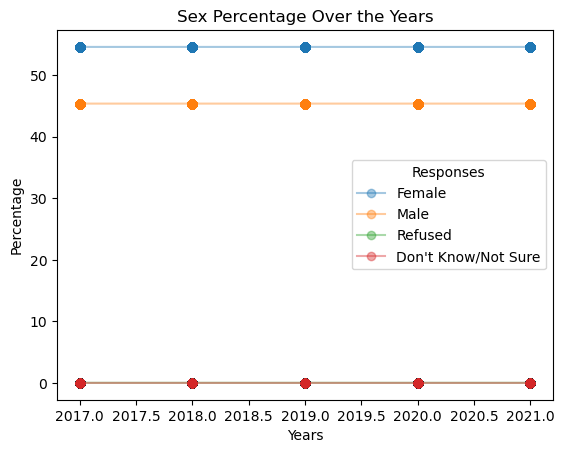

In [10]:
# Get unique responses in the "sex" column
sex_unique = final_df["sex"].unique()
sex_total = final_df["sex"].count()
# Create a dictionary to map responses to custom labels
sex_labels = {
    1: "Male",
    2: "Female",
    7:"Don't Know/Not Sure",
    9: "Refused"
}

for response in sex_unique:
    response_count = (final_df["sex"] == response).sum()
    percentage = (response_count / sex_total) * 100
    plt.plot(final_df.index, [percentage] * sex_total, marker='o', alpha=0.4, label=f'{sex_labels.get(response, response)} Percentage')

legend_labels = [f'{sex_labels.get(response, response)}' for response in sex_unique]
plt.legend(legend_labels, title="Responses")

plt.xlabel("Years")
plt.ylabel("Percentage")
plt.title("Sex Percentage Over the Years")
plt.show()

In [11]:
valid_education_values = [1, 2, 3, 4, 5, 6, 9]
filtered_final_df = final_df[final_df["education"].isin(valid_education_values)]

def round_to_nearest_valid(value):
    return min(valid_education_values, key=lambda x: abs(x - value))

filtered_final_df.loc[:, "education"] = filtered_final_df["education"].apply(round_to_nearest_valid)

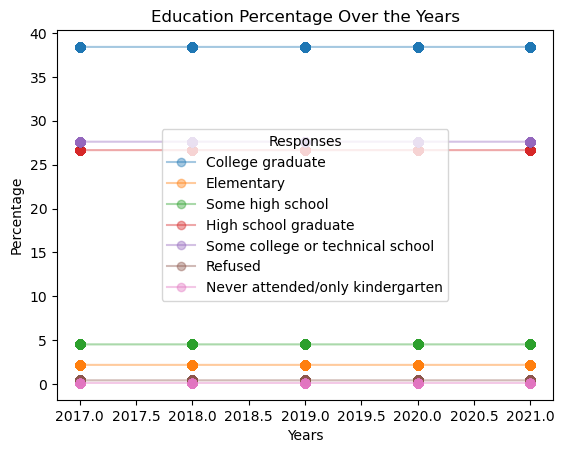

In [12]:
education_unique = filtered_final_df["education"].unique()
education_total = filtered_final_df["education"].count()
education_labels = {
    1: "Never attended/only kindergarten",
    2: "Elementary",
    3: "Some high school",
    4: "High school graduate",
    5: "Some college or technical school",
    6: "College graduate",
    9: "Refused"
}

for response in education_unique:
    response_count = (filtered_final_df["education"] == response).sum()
    percentage = (response_count / education_total) * 100
    plt.plot(filtered_final_df.index, [percentage] * education_total, marker='o', alpha=0.4, label=f'{education_labels.get(response, response)} Percentage')

legend_labels = [f'{education_labels.get(response, response)}' for response in education_unique]
plt.legend(legend_labels, title="Responses", fontsize=10)

plt.xlabel("Years")
plt.ylabel("Percentage")
plt.title("Education Percentage Over the Years")
plt.show()

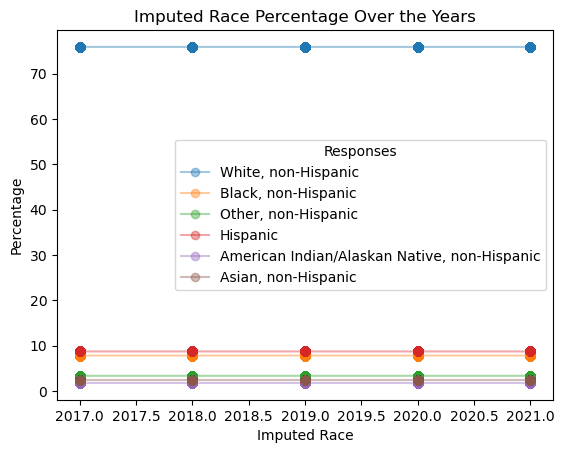

In [13]:
imputed_race_unique = final_df["imputed_race"].unique()
imputed_race_total = final_df["imputed_race"].count()
imputed_race_labels = {
    1: "White, non-Hispanic",
    2: "Black, non-Hispanic",
    3: "Asian, non-Hispanic",
    4: "American Indian/Alaskan Native, non-Hispanic",
    5: "Hispanic",
    6: "Other, non-Hispanic"
}

for response in imputed_race_unique:
    response_count = (final_df["imputed_race"] == response).sum()
    percentage = (response_count / imputed_race_total) * 100
    plt.plot(final_df.index, [percentage] * imputed_race_total, marker='o', alpha=0.4, label=f'{imputed_race_labels.get(response, response)} Percentage')

legend_labels = [f'{imputed_race_labels.get(response, response)}' for response in imputed_race_unique]
plt.legend(legend_labels, title="Responses")

plt.xlabel("Imputed Race")
plt.ylabel("Percentage")
plt.title("Imputed Race Percentage Over the Years")
plt.show()

### Notes on Data Imbalances and Resampling

We see that there are certain absolute and/or simple majorities present in each explored variable of interest. Females are the absolute majority sex, college graduates are the simple majority education level, and whites (non-Hispanics) are the absolute majority imputed race. While it is possible to resample the data and create a balanced dataset, we decided not to resample the data at this time in order to maintain the representativeness and interpretability of the dataset.

For example, there is a slightly larger percentage of females than males in the USA and the US Census Bureau estimated that the USA was ~75% white in 2022 which aligns with the percentages on our graphs. The aim is to reflect real-world demographics and ensure that our findings are applicable to broader populations. By not artificially balancing the data, we preserve the natural variations in demographic factors. We will instead address these imbalances by ensuring that each class is adequately represented in both training and testing sets. 

The line graphs depicting percentages of sex, education, and imputed race variables of interest consistently show similar patterns over the five-year period, appearing as horizontal lines for each response. The stability in these percentages raises questions about potential data calculation errors or variations in data collection methods. Given the relatively short timeframe and minimal reported changes in data collection processes, it is possible that these findings reflect the consistent nature of these demographic attributes throughout the five-year span. This is something we will further analyze in future work.


## <div class='exercise'><b> Data Scaling</b></div>


### Notes on Data Scaling and Weighing

The BRFSS uses *data weighing* to make its sample more representative of the adult population of the United States. Its weighing methodology comprises of a **design weight** that compensates for an individuals' probability of selection and a **demographic adjustment** to weight under-or-over sampled populations towards their true population proportion/importance with iterative proportional fitting or raking. Each year contains new weights calculated for that year's survey, most notably an updated **_LLCPWT** weight for the Combined Land Line and Cell Phone data. This weight contains the required significance scaling for each observation based on their demographics and representation in the sample.


According to a memo accompanying the 2021 BRFSS data, [Complex Sampling Weights and Preparing Module Data for Analysis](https://www.cdc.gov/brfss/annual_data/2021/pdf/Complex-Sampling-Weights-and-Preparing-Module-Data-for-Analysis-2021-508.pdf), "Researchers conducting analysis of variables from the core-only section should use the variable _LLCPWT for weighting" (CDC 2021:2). As our analysis relies primarily on variables generated by questions from the core-only section, we will be utilizing _LLCPWT.

In [14]:
# Weights present in final dataframe
final_df.filter(regex='wt').head()

,_llcpwt2,_wt2rake_miss,_strwt,_llcpwt,_strwt_miss,_llcpwt2_miss,_wt2rake,_llcpwt_miss
year,,,,,,,,
2017,185.477444,0,26.296801,79.425947,0,0,26.296801,0
2017,185.477444,0,26.296801,89.694580,0,0,26.296801,0
2017,370.954888,0,26.296801,440.121376,0,0,52.593603,0
2017,185.477444,0,26.296801,194.867164,0,0,26.296801,0
2017,252.493865,0,26.296801,169.087888,0,0,26.296801,0


It seems that **sklearn** has the ability to utilize weights within its models, but we will research the specificities of how to use sampling weights before the next Milestone.

### Editing Data Types

There are a few variables within the data set that are stored in numeric formats that may be better stored in another data type. For example, the variables storing the date of an interview are nominal categorical variables stored as a numeric variable. They will be better as Python *datetime* objects.  

In [15]:
# Example of converting from numeric to date time

# Subset final_df
final_df_subset = final_df.head(50).copy()

# Convert 'idate' into date time object
final_df_subset['idate'] = pd.to_datetime(final_df_subset['idate'], format= "%m%d%Y")

# Show converted idate column
final_df_subset['idate'].head()

year
2017   2017-01-30
2017   2017-11-02
2017   2017-01-10
2017   2017-02-08
2017   2017-01-30
Name: idate, dtype: datetime64[ns]